In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import matplotlib
import scipy.stats as stats
# from custom_models import InferenceDropout, MCDropout, gaussian_loss

In [3]:
with open('x_test_values.pickle', 'rb') as file:
    x_test_values = pickle.load(file)

with open('y_test.pickle', 'rb') as file:
    y_test = pickle.load(file)

print(len(x_test_values))

1392


In [4]:
model = tf.keras.models.load_model('model.keras')

In [5]:
dftrain = pd.read_csv("data/plasticc_train_metadata.csv")

dftest = pd.read_csv("data/plasticc_test_metadata.csv")

dftest = dftest[:20000]

dftest['target'] = dftest['true_target']

dftrain = pd.concat([dftrain, dftest], axis=0, ignore_index=True)

sn_models = [90, 67, 52, 42, 62, 95, 15]
dftrain = dftrain[dftrain['target'].isin(sn_models)]


In [6]:
def split(array, length):
    # print(length)
    new_array = np.zeros((352, 4))
    for i in range(int(length)):
        for j in range(4):
            new_array[i][j] = array[i][j]
    return new_array

def mc_dropout(mod, idx, samples=10, percent = 1.00):
    length = 0
    for i in range(1, len(x_test_values[idx])):
        if x_test_values[idx][i][0] == 0:
            length = i + 1
            break
        elif i == len(x_test_values[idx]) - 1:
            length = 352
            break
    # print(np.array([x_test_values[idx]] * samples).shape)
    predictions = mod(np.array([split(x_test_values[idx], percent * length)] * samples), training=True)
    predictions = [x[0] for x in predictions]
    mean = np.mean(predictions)
    stdev = np.std(predictions)
    # print(predictions)
    # print(x_test_values[idx][-1], x_test_values[idx][0])
    # print(r, x_test_values[idx][0][0])
    duration = 0
    for i in range(1, len(x_test_values[idx])):
        if x_test_values[idx][i][0] == 0:
            duration = x_test_values[idx][i - 1][0] - x_test_values[idx][0][0]
            break
        elif i == len(x_test_values[idx]) - 1:
            duration = x_test_values[idx][i][0] - x_test_values[idx][0][0]
            break

    y_actual = y_test[idx][1]
    # print(duration)
    # print(abs(mean - y_actual) * 2000)
    # print(abs(mean - y_actual) / stdev)
    return (abs(mean - y_actual) * 2000, abs(mean - y_actual) / duration * 100)
# print(mc_dropout(model, 1))
# print(model.summary())
# y_pred = model.predict(np.array(x_test_values))
# vals = []
# for i in range(0, 21):
#     vals.append(mc_dropout(model, 6, samples=10, percent=0.75+0.0125*i))
# sum = 0
sums = {90: 0, 67: 0, 52: 0, 42: 0, 62: 0, 95: 0, 15: 0}
avgs = {90: 0, 67: 0, 52: 0, 42: 0, 62: 0, 95: 0, 15: 0}
counts = {90: 0, 67: 0, 52: 0, 42: 0, 62: 0, 95: 0, 15: 0}
# print(y_test[6][0])
for i in range(len(x_test_values[:100])):
    id = dftrain[dftrain['object_id'] == y_test[i][0]]['target'].to_numpy()[0]
    result = mc_dropout(model, i)
    sums[id] += result[0]
    avgs[id] += result[1]
    counts[id] += 1
print(sum(sums.values())/sum(counts.values()))
for i in sums.keys():
    sums[i] = sums[i]/counts[i]
    print(i, sums[i])
print()
for i in avgs.keys():
    avgs[i] = avgs[i]/counts[i]
    print(i, avgs[i])

# mc_dropout(model, 0)

31.64685767433155
90 21.563502409702377
67 17.944269330024298
52 36.125456945419494
42 27.453520187615815
62 79.36545913696173
95 70.15996835422446
15 25.242143104551307

90 2.436348226330659
67 1.755860815042368
52 4.137627981424572
42 2.796931937666526
62 9.276302647924332
95 7.02606677751525
15 2.741469757503836


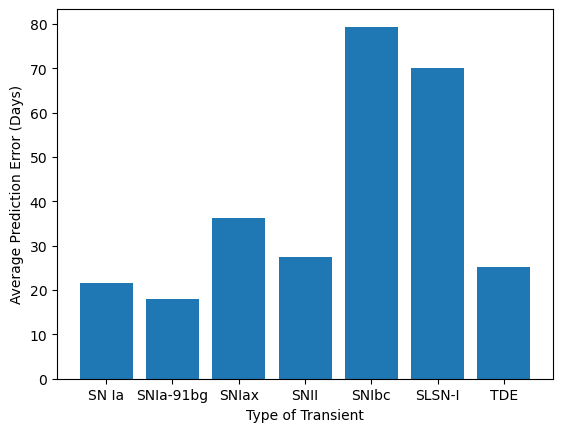

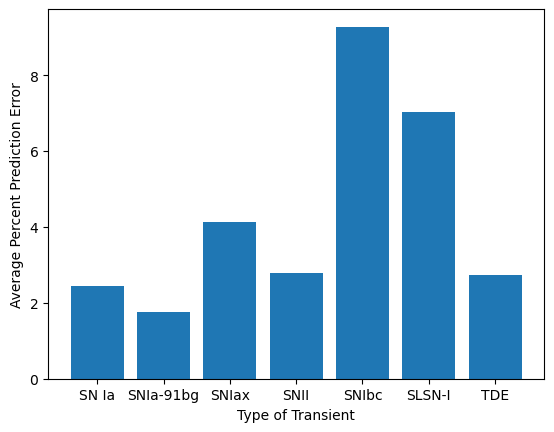

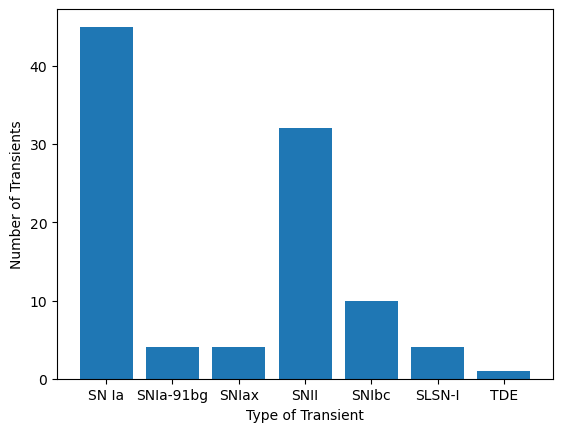

In [7]:
model_nums = {90:'SN Ia', 67:'SNIa-91bg', 52:'SNIax', 42:'SNII', 62:'SNIbc', 95:'SLSN-I', 15:'TDE', 64:'KN', 88:'AGN', 92:'RRL', 65:'M-dwarf', 16:'EB', 53:'Mira', 6:'muLens-Single', 991:'muLens-Binary', 992:'ILOT', 993:'CaRT', 994:'PISN', 995:'muLens-String'}
def display_dict(dictionary, y_label, name):
    plt.bar([model_nums[i] for i in dictionary.keys()], dictionary.values())

    plt.xlabel("Type of Transient")
    plt.ylabel(y_label)
    plt.savefig(name, bbox_inches='tight', dpi=500)
    plt.show()

display_dict(sums, "Average Prediction Error (Days)", 'images/avgprederror.png')
display_dict(avgs, "Average Percent Prediction Error", 'images/avgpercerror.png')
display_dict(counts, "Number of Transients", 'images/numbertransient.png')

In [8]:
lcs = pd.read_csv("data/plasticc_train_lightcurves.csv")

lcs_test = pd.read_csv("data/plasticc_test_lightcurves_01.csv")

lcs = pd.concat([lcs, lcs_test[:3000000]], axis=0, ignore_index=True)

In [9]:
def display_object(object_id, lightcurve_data, metadata, mean=0, stdev=0):
    lightcurve_data = lightcurve_data[lightcurve_data['object_id'] == object_id]
    passbands = []
    true_peaktime = metadata[metadata['object_id'] == object_id]['true_peakmjd']
    
    fig, ax = plt.subplots()

    # ax.plot([true_peaktime.values[0], true_peaktime.values[0]], [-30,45], label = "Real Peak Time", color='black')
    if mean > 0:
        # ax.plot([mean - stdev, mean - stdev], [-45, 45])
        # plt.plot([mean + stdev, mean + stdev], [-45, 45])
        x = np.linspace(mean - 3 * stdev, mean + 3 * stdev, 100)
        y = 45*stdev*((2*3.14159)**0.5)*stats.norm.pdf(x, mean, stdev)
        ax.fill_between(x, y, 0, color='blue', label="Predicted Peak Time Distribution", alpha=0.3)

        # ax.plot(x, 45*stdev*((2*3.14159)**0.5)*stats.norm.pdf(x, mean, stdev), color='blue', label = "Predicted Peak Time Distribution")
        # rect = matplotlib.patches.Rectangle((mean - stdev, -30), 2 * stdev, 75, facecolor='blue', edgecolor='blue', linewidth=0, alpha=0.2)
        # ax.add_patch(rect)
    for freq in range(6):
        passbands.append(lightcurve_data[lightcurve_data['passband'] == freq][['mjd', 'flux']])
    mapping = {
         0: 'u (300-400 nm)', 1:'g (400-600 nm)', 2:'r (500-700 nm)', 3:'i (650-850 nm)', 4:'z (800-950 nm)', 5:'y (950-1050 nm)'
    }
    for i in range(len(passbands)):
        ax.scatter(passbands[i]['mjd'], passbands[i]['flux'], label=mapping[i])
        # print(true_peaktime)
    # ax.plot([mean, mean], [-30, 45], label = r"Predicted Peak Time $\pm\sigma$", color='blue', alpha=1)
    ax.plot([true_peaktime.values[0], true_peaktime.values[0]], [0,45], label = "Real Peak Time", color='black')

    plt.xlabel("Modified Julien Date")
    # plt.xlim([60500,60700])
    plt.ylabel("Flux")
    plt.title("Flux vs. Time")
    plt.legend(ncol=1)
    
    # plt.show()
    plt.savefig('images/transient6fluxvstime.png', bbox_inches='tight', dpi=500)
    plt.show()


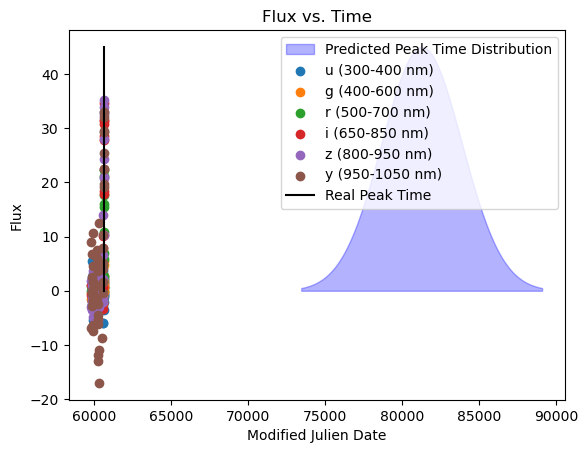

In [10]:
mean, stdev = mc_dropout(model, 6, samples=100)
display_object(y_test[6][0], lcs, dftrain, mean=mean * 2000 + 59000, stdev=stdev * 2000)
# display_object(y_test[6][0], lcs, dftrain)

In [11]:
# def plot_error(arr):
#     time = [v[0] for v in arr]
#     prediction = [v[1][0] for v in arr]
#     stdev = [v[1][1] for v in arr]

#     plt.errorbar(time, prediction, yerr=stdev, fmt='-', capsize=5, label=r'Peak Time Prediction $\pm\sigma$')
#     plt.xlabel('Days Until Peak Time')
#     plt.ylabel('Prediction Error (Days)')
#     plt.title('Prediction Error vs. Time Until Peak')
#     plt.legend(loc='lower right')
#     plt.savefig('images/transient6errorvstime.png', bbox_inches='tight', dpi=500)
#     plt.show()

# # print(vals)
# plot_error(vals)